In [85]:
!pip install pymongo

In [1]:
from pymongo import MongoClient

In [57]:
# * VERY IMPORTANT TO CONFIG HERE
mongo_url = 'mongodb://localhost'
db_name = 'test'
collection_name = 'test_collection'
column_name = 'data'

client = MongoClient(mongo_url)
db=client[db_name]
collection = db[collection_name]

In [74]:
prod_id_list = [i['_id'] for i in list(collection.aggregate([{"$group": {"_id": "$producer_id"}}]))]
print('\n<>______START COUNT LOSS__________')
print(f'Producer IDs:')
for index, val in enumerate(prod_id_list):
    print(f'{index+1}. {val}')
    for index, prod_id in enumerate(prod_id_list):
        dataListOfProd = [i for i in list(
            collection.find({"producer_id": prod_id}))]
        print(pd.DataFrame([i['timestamp_producer']
                                   for i in dataListOfProd],).diff().fillna(0).describe())

    print('<>______END COUNT LOSS__________\n')



<>______START COUNT LOSS__________
Producer IDs:
1. f3fdf026-f424-4dde-acec-320b66b39740
                 0
count   558.000000
mean   2997.526882
std     127.130004
min       0.000000
25%    3002.000000
50%    3003.000000
75%    3004.000000
max    3017.000000
                 0
count   558.000000
mean   2997.507168
std     127.128552
min       0.000000
25%    3002.000000
50%    3003.000000
75%    3004.000000
max    3018.000000
<>______END COUNT LOSS__________

2. 74d5e630-9d3a-4d79-bb96-507f5fb19584
                 0
count   558.000000
mean   2997.526882
std     127.130004
min       0.000000
25%    3002.000000
50%    3003.000000
75%    3004.000000
max    3017.000000
                 0
count   558.000000
mean   2997.507168
std     127.128552
min       0.000000
25%    3002.000000
50%    3003.000000
75%    3004.000000
max    3018.000000
<>______END COUNT LOSS__________



In [78]:
pd.DataFrame([i['timestamp_producer'] for i in dataListOfProd], columns=["prod"]).diff().fillna(0)


,prod
0,0.0
1,3002.0
2,3004.0
3,3003.0
4,3003.0
...,...
553,3004.0
554,3002.0
555,3008.0
556,3001.0


In [58]:
import pandas as pd
data = pd.DataFrame( list(collection.find({})))
data.tail()

,_id,topic,partition,timestamp_kafka,timestamp_db,sequence_num,data,timestamp_producer,producer_id
58,61a3982735638e614139dd76,test-topic,0,1638111269575,1.638111e+12,403,0.635679,1.638111e+12,f3fdf026-f424-4dde-acec-320b66b39740
59,61a3982735638e614139dd77,test-topic,0,1638111271077,1.638111e+12,403,-0.460716,1.638111e+12,74d5e630-9d3a-4d79-bb96-507f5fb19584
60,61a3982835638e614139dd78,test-topic,2,1638111272578,1.638111e+12,404,1.330498,1.638111e+12,f3fdf026-f424-4dde-acec-320b66b39740
61,61a3982a35638e614139dd79,test-topic,2,1638111274081,1.638111e+12,404,-0.618748,1.638111e+12,74d5e630-9d3a-4d79-bb96-507f5fb19584
62,61a3982b35638e614139dd7a,test-topic,1,1638111275581,1.638111e+12,405,-0.949054,1.638111e+12,f3fdf026-f424-4dde-acec-320b66b39740


In [31]:
print('Current data count: ', data.shape)

Current data count:  (5418, 9)


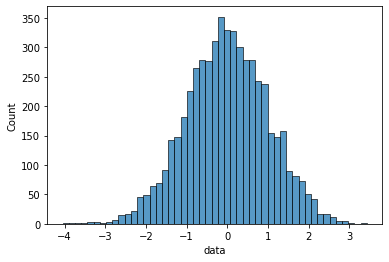

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.histplot(data=data, x=column_name)
plt.show()

# Throughput calculation TEST

In [39]:
time_data = data[['timestamp_kafka', 'timestamp_db', 'timestamp_producer']]
time_data.head()



,timestamp_kafka,timestamp_db,timestamp_producer
0,1638110119445,1.638110e+12,1.638110e+12
1,1638110131454,1.638110e+12,1.638110e+12
2,1638110120946,1.638110e+12,1.638110e+12
3,1638110128452,1.638110e+12,1.638110e+12
4,1638110129957,1.638110e+12,1.638110e+12


In [59]:
ts_kafka = data['timestamp_producer']

ts_kafka.astype('int64').diff().fillna(0).describe()


count      63.000000
mean     1477.634921
std       503.197560
min     -1494.000000
25%      1497.500000
50%      1501.000000
75%      1504.000000
max      3004.000000
Name: timestamp_producer, dtype: float64

In [68]:
import numpy as np
time_data = time_data.astype(np.int64)

delay_data = pd.DataFrame(
    columns=['delay_producer_kafka', 'delay_kafka_db', 'delay_producer_db'])

delay_data['delay_producer_kafka'] = time_data['timestamp_kafka'] - \
    time_data['timestamp_producer']
delay_data['delay_kafka_db'] = time_data['timestamp_db'] - \
    time_data['timestamp_kafka']
delay_data['delay_producer_db'] = time_data['timestamp_db'] - \
    time_data['timestamp_kafka']


print(delay_data.tail())


      delay_producer_kafka  delay_kafka_db  delay_producer_db
6431                     0             503                503
6432                     2               3                  3
6433                     0            1512               1512
6434                     0               3                  3
6435                     0               6                  6


In [69]:
start_time = time_data.min().min()
print('start time: ', start_time)

start time:  1636958278190


In [70]:
time_data = time_data + start_time
time_data.head()

,timestamp_kafka,timestamp_db,timestamp_producer
0,3273916556387,3273916556450,3273916556387
1,3273916556380,3273916556438,3273916556380
2,3273916559388,3273916559393,3273916559388
3,3273916559380,3273916559419,3273916559380
4,3273916562381,3273916562387,3273916562381


In [71]:
end_time = time_data.max().max()
print('time from start to end of test: ', end_time, 'in minutes: ', end_time/1000/60)

time from start to end of test:  3274530592771 in minutes:  54575509.87951667


In [75]:
time_data.head()
concat_pd = pd.concat([time_data,delay_data], axis=1)
concat_pd.head()


,timestamp_kafka,timestamp_db,timestamp_producer,delay_producer_kafka,delay_kafka_db,delay_producer_db
0,3273916556387,3273916556450,3273916556387,0,63,63
1,3273916556380,3273916556438,3273916556380,0,58,58
2,3273916559388,3273916559393,3273916559388,0,5,5
3,3273916559380,3273916559419,3273916559380,0,39,39
4,3273916562381,3273916562387,3273916562381,0,6,6


In [60]:
# through put: counting over intervals
interval = 10000 # 10 secs
start = 0
end = end_time
grouped_by_interval = time_data["delay_producer_kafka"]
grouped_by_interval = grouped_by_interval.groupby(pd.cut(grouped_by_interval, np.arange(start, end, interval))).count()
throughput = grouped_by_interval/(interval/1000)
throughput.describe()


count    61250.000000
mean         0.000614
std          0.151927
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         37.600000
Name: delay_producer_kafka, dtype: float64

In [54]:
# through put: counting over intervals
interval = 10000  # 10 secs
start = 0
end = end_time
grouped_by_interval = time_producer_kafka
grouped_by_interval = grouped_by_interval.groupby(
    pd.cut(grouped_by_interval, np.arange(start, end, interval))).count()
throughput = grouped_by_interval/(interval/1000)
throughput.describe()


count    61250.000000
mean         0.000521
std          0.128895
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         31.900000
dtype: float64

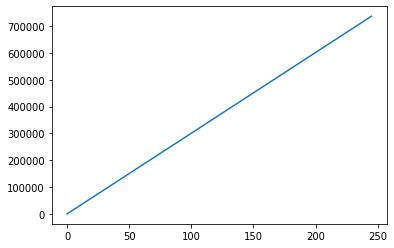

In [97]:
plt.plot(time_data["timestamp_producer"])